# Graph Attention Networks (GAT) - Complete Professional Implementation

This notebook provides a comprehensive implementation of Graph Attention Networks (GAT) based on the paper "Graph Attention Networks" by Veličković et al.

### Key Features:
- ✅ Multi-head attention mechanism
- ✅ Professional training pipeline with early stopping
- ✅ Comprehensive evaluation metrics
- ✅ Visualization capabilities
- ✅ Error handling and logging

### Architecture Overview:
GATs work on graph data where nodes represent entities and edges represent relationships. The attention mechanism allows nodes to focus on the most relevant neighbors, similar to transformers but adapted for graph structures.

## 1. Importing Required Libraries

In [67]:
# Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from safetensors.torch import save_file, load_file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.preprocessing import LabelEncoder
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator, Descriptors
import networkx as nx
from datetime import datetime
import time
import warnings
import os
import json

In [68]:
warnings.filterwarnings('ignore')


# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
# Memory optimization settings for GPU, Aggressive memory management
if device.type == 'cuda':
    torch.cuda.empty_cache()
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
    
    # Force garbage collection
    import gc
    gc.collect()
    
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    print("Memory optimization enabled ✓")

# specific style date time saving
timestamp = datetime.now().strftime("%d_%b_%H-%M")

# validating required directories:
required_directories = ['images', 'models', 'results']
for folder in required_directories:
    if not os.path.exists(folder):
        print(f"Directory `{folder}/` not found ✘ Creating...")
        os.makedirs(folder)
    else:
        print(f"Directory `{folder}/` exists ✓")

Using device: cuda
GPU: NVIDIA GeForce GTX 1650
GPU Memory: 4.00 GB
Memory optimization enabled ✓
Directory `images/` exists ✓
Directory `models/` exists ✓
Directory `results/` not found ✘ Creating...


In [69]:
# Load DDI data
print("="*60)
print("EXPLORING DRUG-DRUG INTERACTION DATASET")
print("="*60)

# Load DDI interactions
ddi_df = pd.read_csv('dataset/drugdata/ddis.csv')
print(f"\n📊 DDI Dataset Shape: {ddi_df.shape}")
print(f"Columns: {ddi_df.columns.tolist()}")
print(f"\n🔬 Interaction Types Distribution:")
print(ddi_df['type'].value_counts())
print(f"\n📋 Sample DDI Data:")
print(ddi_df.head(10))

# Load drug SMILES
smiles_df = pd.read_csv('dataset/drugdata/drug_smiles.csv')
print(f"\n💊 Drug SMILES Dataset Shape: {smiles_df.shape}")
print(f"Columns: {smiles_df.columns.tolist()}")
print(f"\n📋 Sample SMILES Data:")
print(smiles_df.head(10))

# Get unique drugs
unique_drugs_ddi = set(ddi_df['d1'].unique()) | set(ddi_df['d2'].unique())
print(f"\n📈 Statistics:")
print(f"• Total DDI pairs: {len(ddi_df)}")
print(f"• Unique drugs in DDI: {len(unique_drugs_ddi)}")
print(f"• Drugs with SMILES: {len(smiles_df)}")
print(f"• Interaction type 0: {(ddi_df['type'] == 0).sum()}")
print(f"• Interaction type 1: {(ddi_df['type'] == 1).sum()}")

# Check overlap
drugs_with_smiles = set(smiles_df['drug_id'].unique())
overlap = unique_drugs_ddi & drugs_with_smiles
print(f"• Drugs with both DDI and SMILES: {len(overlap)}")
print(f"• Coverage: {len(overlap)/len(unique_drugs_ddi)*100:.2f}%")

EXPLORING DRUG-DRUG INTERACTION DATASET

📊 DDI Dataset Shape: (191808, 4)
Columns: ['d1', 'd2', 'type', 'Neg samples']

🔬 Interaction Types Distribution:
type
48    60751
46    34360
72    23779
74     9470
59     8397
      ...  
42       11
61       11
51       10
25        7
41        6
Name: count, Length: 86, dtype: int64

📋 Sample DDI Data:
        d1       d2  type Neg samples
0  DB04571  DB00460     0   DB01579$t
1  DB00855  DB00460     0   DB01178$t
2  DB09536  DB00460     0   DB06626$t
3  DB01600  DB00460     0   DB01588$t
4  DB09000  DB00460     0   DB06196$t
5  DB11630  DB00460     0   DB00744$t
6  DB00553  DB00460     0   DB06413$t
7  DB06261  DB00460     0   DB00876$t
8  DB01878  DB00460     0   DB09267$t
9  DB00140  DB00460     0   DB01204$t

💊 Drug SMILES Dataset Shape: (1706, 2)
Columns: ['drug_id', 'smiles']

📋 Sample SMILES Data:
   drug_id                                             smiles
0  DB04571                CC1=CC2=CC3=C(OC(=O)C=C3C)C(C)=C2O1
1  DB00855     

In [70]:
def prepare_ddi_data():
    """
    Load and prepare DDI data
    """
    print("_"*40)
    print("LOADING DRUG-DRUG INTERACTION DATA")
    print("-"*40)
    
    # Load data
    ddi_df = pd.read_csv('dataset/drugdata/ddis.csv')
    smiles_df = pd.read_csv('dataset/drugdata/drug_smiles.csv')
    
    print(f"✓ Loaded {len(ddi_df)} DDI pairs")
    print(f"✓ Loaded {len(smiles_df)} drug SMILES")
    print("_"*40)
    
    # Extract features
    feature_extractor = DrugFeatureExtractor()
    drug_features = feature_extractor.extract_all_features(smiles_df)
    
    # Build graph
    graph_builder = DDIGraphBuilder(ddi_df, drug_features)
    node_features, edge_index, edge_labels, n_classes = graph_builder.build_graph()
    
    # Create adjacency matrix
    n_nodes = node_features.shape[0]
    adj_mat = torch.zeros(n_nodes, n_nodes, 1)
    adj_mat[edge_index[0], edge_index[1], 0] = 1
    
    # Add self-loops
    adj_mat[range(n_nodes), range(n_nodes), 0] = 1
    
    # Split data
    n_edges = edge_index.shape[1]
    indices = np.arange(n_edges)
    
    train_idx, temp_idx = train_test_split(indices, test_size=0.3, random_state=42)
    val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)
    
    train_mask = torch.zeros(n_edges, dtype=torch.bool)
    val_mask = torch.zeros(n_edges, dtype=torch.bool)
    test_mask = torch.zeros(n_edges, dtype=torch.bool)
    
    train_mask[train_idx] = True
    val_mask[val_idx] = True
    test_mask[test_idx] = True
    
    print(f"\n🛈 Data Split:")
    print(f"• Train: {train_mask.sum()} edges ({train_mask.sum()/n_edges*100:.1f}%)")
    print(f"• Val: {val_mask.sum()} edges ({val_mask.sum()/n_edges*100:.1f}%)")
    print(f"• Test: {test_mask.sum()} edges ({test_mask.sum()/n_edges*100:.1f}%)")
    
    return {
        'node_features': node_features,
        'edge_index': edge_index,
        'edge_labels': edge_labels,
        'adj_mat': adj_mat,
        'train_mask': train_mask,
        'val_mask': val_mask,
        'test_mask': test_mask,
        'n_classes': n_classes,
        'label_encoder': graph_builder.label_encoder
    }

## 3. Feature and Pattern Extraction

In [71]:
class DrugFeatureExtractor:
    """
    Extract molecular features from SMILES strings using RDKit
    """
    
    def __init__(self):
        self.feature_names = []
    
    def smiles_to_features(self, smiles):
        """
        Convert SMILES to molecular fingerprint and descriptors
        
        Args:
            smiles: SMILES string
            
        Returns:
            Feature vector
        """
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return None
            
            # Morgan fingerprint
            mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024)
            fp = fp = mfpgen.GetFingerprint(mol)
            fp_array = np.array(fp)
            
            # Molecular descriptors
            descriptors = [
                Descriptors.MolWt(mol),
                Descriptors.MolLogP(mol),
                Descriptors.NumHDonors(mol),
                Descriptors.NumHAcceptors(mol),
                Descriptors.TPSA(mol),
                Descriptors.NumRotatableBonds(mol),
                Descriptors.NumAromaticRings(mol),
                Descriptors.FractionCSP3(mol),
            ]
            
            # Combine fingerprint and descriptors
            features = np.concatenate([fp_array, descriptors])
            
            return features
            
        except Exception as e:
            print(f"Error processing SMILES: {e}")
            return None
    
    def extract_all_features(self, smiles_df):
        """
        Extract features for all drugs
        
        Args:
            smiles_df: DataFrame with drug_id and smiles columns
            
        Returns:
            Dictionary mapping drug_id to feature vector
        """
        print("\n"+"_"*45)
        print("Extracting molecular features from SMILES...")
        print("-"*45)

        drug_features = {}
        failed = 0
        
        for idx, row in smiles_df.iterrows():
            drug_id = row['drug_id']
            smiles = row['smiles']
            
            features = self.smiles_to_features(smiles)
            
            if features is not None:
                drug_features[drug_id] = features
            else:
                failed += 1
            
            if (idx + 1) % 200 == 0:
                print(f"{idx + 1}/{len(smiles_df)} drugs processed ")
        print("-"*45)
        print(f"✓ Extracted features for {len(drug_features)} drugs")
        if failed > 0:
            print(f"⚠ Failed to process {failed} drugs")
        print("_"*45 + "\n")
        return drug_features

## 4. GAT Architecture Building

In [72]:
class DDIGraphBuilder:
    """
    Build graph structure from DDI data
    """
    
    def __init__(self, ddi_df, drug_features):
        self.ddi_df = ddi_df
        self.drug_features = drug_features
        self.drug_to_idx = {}
        self.idx_to_drug = {}
        self.label_encoder = LabelEncoder()
        
    def build_graph(self):
        """
        Build graph from DDI data
        
        Returns:
            Node features, edge indices, edge labels
        """
        print("_"*40)
        print("Building DDI graph...")
        
        # Get unique drugs
        unique_drugs = sorted(list(self.drug_features.keys()))
        self.drug_to_idx = {drug: idx for idx, drug in enumerate(unique_drugs)}
        self.idx_to_drug = {idx: drug for drug, idx in self.drug_to_idx.items()}
        
        print(f"• Number of nodes (drugs): {len(unique_drugs)}")
        
        # Create node feature matrix
        feature_dim = len(list(self.drug_features.values())[0])
        node_features = np.zeros((len(unique_drugs), feature_dim))
        
        for drug, idx in self.drug_to_idx.items():
            node_features[idx] = self.drug_features[drug]
        
        # Normalize features
        node_features = (node_features - node_features.mean(axis=0)) / (node_features.std(axis=0) + 1e-8)
        
        # Build edges from DDI data
        edge_list = []
        edge_labels = []
        
        for _, row in self.ddi_df.iterrows():
            d1, d2, interaction_type = row['d1'], row['d2'], row['type']
            
            if d1 in self.drug_to_idx and d2 in self.drug_to_idx:
                idx1 = self.drug_to_idx[d1]
                idx2 = self.drug_to_idx[d2]
                
                # Add bidirectional edges
                edge_list.append([idx1, idx2])
                edge_list.append([idx2, idx1])
                edge_labels.append(interaction_type)
                edge_labels.append(interaction_type)
        
        edge_index = torch.tensor(edge_list, dtype=torch.long).t()
        
        # Encode labels
        edge_labels = self.label_encoder.fit_transform(edge_labels)
        edge_labels = torch.tensor(edge_labels, dtype=torch.long)
        
        print(f"• Number of edges: {len(edge_list)}")
        print(f"• Number of interaction types: {len(self.label_encoder.classes_)}")
        print(f"• Feature dimension: {feature_dim}")
        
        return (
            torch.FloatTensor(node_features),
            edge_index,
            edge_labels,
            len(self.label_encoder.classes_)
        )

In [73]:
class GraphAttentionLayer(nn.Module):
    """
    Single Graph Attention Layer Implementation
    
    Args:
        in_features: Number of input features per node (F)
        out_features: Number of output features per node (F')
        n_heads: Number of attention heads (K)
        is_concat: Whether to concatenate or average multi-head results
        dropout: Dropout probability for regularization
        leaky_relu_negative_slope: Negative slope for LeakyReLU activation
    """
    
    def __init__(self, in_features: int, out_features: int, n_heads: int=8, 
                 is_concat: bool = True, dropout: float = 0.6, 
                 leaky_relu_negative_slope: float = 0.2):
        super().__init__()
        
        self.is_concat = is_concat
        self.n_heads = n_heads
        
        # Calculate dimensions per head
        if is_concat:
            assert out_features % n_heads == 0, "out_features must be divisible by n_heads when concatenating"
            self.n_hidden = out_features // n_heads
        else:
            self.n_hidden = out_features
        
        # Linear transformation: W in the paper
        self.linear = nn.Linear(in_features, self.n_hidden * n_heads, bias=False)
        
        # Attention parameters (a^T) (one per head)
        self.attn_src = nn.Parameter(torch.Tensor(1, n_heads, self.n_hidden))
        self.attn_dst = nn.Parameter(torch.Tensor(1, n_heads, self.n_hidden))
        
        # Activation and normalization
        self.activation = nn.LeakyReLU(negative_slope=leaky_relu_negative_slope)
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(dropout)
        
        # Initialize weights using Xavier uniform
        self._init_weights()
    
    def _init_weights(self):
        """Initialize layer weights using Xavier uniform initialization"""
        nn.init.xavier_uniform_(self.linear.weight)
        nn.init.xavier_uniform_(self.attn_src)
        nn.init.xavier_uniform_(self.attn_dst)
    
    def forward(self, h: torch.Tensor, adj_mat: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the attention layer
        
        Args:
            h: Node embeddings [n_nodes, in_features]
            adj_mat: Adjacency matrix [n_nodes, n_nodes, n_heads]
            
        Returns:
            Updated node embeddings [n_nodes, out_features]
        """
        n_nodes = h.shape[0]
        device = h.device
        
        # Step 1: Linear transformation g_i = W * h_i for each head
        g = self.linear(h).view(n_nodes, self.n_heads, self.n_hidden)

        # Extract edge indices from adjacency matrix (ony non-zero entries)
        adj_2d = adj_mat.squeeze(-1)
        edge_index = adj_2d.nonzero(as_tuple=False).t()

        if edge_index.shape[1] == 0:
            # No edges case
            if self.is_concat:
                return torch.zeros(n_nodes, self.n_heads * self.n_hidden, device=device)
            else:
                return torch.zeros(n_nodes, self.n_hidden, device=device)
        
        src_nodes = edge_index[0]
        dst_nodes = edge_index[1]
        
        # Get features for source and destination nodes
        g_src = g[src_nodes]  # [n_edges, n_heads, n_hidden]
        g_dst = g[dst_nodes]  # [n_edges, n_heads, n_hidden]
        
        # Compute attention scores (edge-wise, memory efficient)
        e_src = (g_src * self.attn_src).sum(dim=-1)  # [n_edges, n_heads]
        e_dst = (g_dst * self.attn_dst).sum(dim=-1)  # [n_edges, n_heads]
        e = self.activation(e_src + e_dst)  # [n_edges, n_heads]
        
        # Softmax normalization per destination node
        # Group by destination node for proper normalization
        alpha = torch.zeros_like(e)
        # Process each head separately to save memory
        for head in range(self.n_heads):
            e_head = e[:, head]
            
            # Use scatter operations instead of loops
            # Create index for scatter
            max_dst = dst_nodes.max().item() + 1
            
            # Compute max for numerical stability
            max_vals = torch.full((max_dst,), float('-inf'), device=device)
            max_vals.scatter_reduce_(0, dst_nodes, e_head, reduce='amax', include_self=False)
            
            # Subtract max and exp
            e_stable = e_head - max_vals[dst_nodes]
            exp_e = torch.exp(e_stable)
            
            # Sum exp values per destination
            sum_exp = torch.zeros(max_dst, device=device)
            sum_exp.scatter_add_(0, dst_nodes, exp_e)
            
            # Normalize
            alpha[:, head] = exp_e / (sum_exp[dst_nodes] + 1e-16)
        
        # Aggregate features using attention weights
        out = torch.zeros(n_nodes, self.n_heads, self.n_hidden, device=device)
        
        # Efficient aggregation using scatter_add
        for head in range(self.n_heads):
            # Weighted features for this head
            weighted_features = g_src[:, head, :] * alpha[:, head].unsqueeze(-1)
            
            # Aggregate to destination nodes
            out[:, head, :].scatter_add_(0, 
                                         dst_nodes.unsqueeze(-1).expand(-1, self.n_hidden),
                                         weighted_features)
        
        # Concatenate or average heads
        if self.is_concat:
            return out.reshape(n_nodes, self.n_heads * self.n_hidden)
        else:
            return out.mean(dim=1)


In [74]:
class GAT_DDI(nn.Module):
    """
    Memory-efficient GAT model with gradient checkpointing
    """
    
    def __init__(self, n_features, n_hidden, n_classes, n_heads=8, dropout=0.6):
        super().__init__()
        
        self.dropout = dropout
        
        # GAT layers
        self.gat1 = GraphAttentionLayer(n_features, n_hidden, n_heads, True, dropout)
        self.gat2 = GraphAttentionLayer(n_hidden, n_hidden, n_heads, True, dropout)
        self.gat3 = GraphAttentionLayer(n_hidden, n_hidden // 2, n_heads, True, dropout)
        
        # Edge prediction layers
        self.edge_mlp = nn.Sequential(
            nn.Linear(n_hidden, n_hidden // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(n_hidden // 2, n_hidden // 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(n_hidden // 4, n_classes)
        )
        
        self.dropout_layer = nn.Dropout(dropout)
        
        # Enable gradient checkpointing for memory efficiency
        self.use_checkpointing = True
    
    def _gat_forward(self, x, adj_mat, gat_layer):
        """Helper for gradient checkpointing"""
        return gat_layer(x, adj_mat)
    
    def forward(self, x, adj_mat, edge_index):
        """
        Forward pass with gradient checkpointing
        """
        # Layer 1
        x = self.dropout_layer(x)
        if self.use_checkpointing and self.training:
            x = torch.utils.checkpoint.checkpoint(self._gat_forward, x, adj_mat, self.gat1, use_reentrant=False)
        else:
            x = self.gat1(x, adj_mat)
        x = F.elu(x)
        
        # Layer 2
        x = self.dropout_layer(x)
        if self.use_checkpointing and self.training:
            x = torch.utils.checkpoint.checkpoint(self._gat_forward, x, adj_mat, self.gat2, use_reentrant=False)
        else:
            x = self.gat2(x, adj_mat)
        x = F.elu(x)
        
        # Layer 3
        x = self.dropout_layer(x)
        if self.use_checkpointing and self.training:
            x = torch.utils.checkpoint.checkpoint(self._gat_forward, x, adj_mat, self.gat3, use_reentrant=False)
        else:
            x = self.gat3(x, adj_mat)
        x = F.elu(x)
        
        # Edge prediction
        src_nodes = edge_index[0]
        dst_nodes = edge_index[1]
        
        edge_features = torch.cat([x[src_nodes], x[dst_nodes]], dim=1)
        edge_pred = self.edge_mlp(edge_features)
        
        return edge_pred

## 5. Training Pipeline

Our training pipeline includes:
- Early stopping to prevent overfitting
- Learning rate scheduling
- Comprehensive logging
- Model checkpointing

In [75]:
class DDITrainer:
    """
    Professional trainer for DDI prediction
    """
    
    def __init__(self, model, device):
        self.model = model.to(device)
        self.device = device
        self.history = {
            'train_loss': [], 'val_loss': [],
            'train_acc': [], 'val_acc': [],
            'train_f1': [], 'val_f1': []
        }
    
    def train_epoch(self, x, adj_mat, edge_index, edge_labels, train_mask, optimizer, criterion):
        """Train for one epoch with mini-batch processing"""
        self.model.train()
        
        # Get training edges
        train_indices = torch.where(train_mask)[0]
        n_train = len(train_indices)
        
        # Process in mini-batches to save memory
        batch_size = 7000  # Adjust based on GPU memory
        n_batches = (n_train + batch_size - 1) // batch_size
        
        total_loss = 0
        all_preds = []
        all_labels = []
        
        # Shuffle training indices
        perm = torch.randperm(n_train, device=self.device)
        train_indices = train_indices[perm]
        
        for i in range(n_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, n_train)
            batch_indices = train_indices[start_idx:end_idx]
            
            optimizer.zero_grad()
            
            # Create batch edge index
            batch_edge_index = edge_index[:, batch_indices]
            batch_labels = edge_labels[batch_indices]
            
            # Forward pass
            out = self.model(x, adj_mat, batch_edge_index)
            loss = criterion(out, batch_labels)
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            # Accumulate metrics
            total_loss += loss.item() * len(batch_indices)
            pred = out.max(1)[1]
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())
            
            # Clear cache periodically
            if (i + 1) % 5 == 0:
                torch.cuda.empty_cache()
        
        # Calculate metrics
        avg_loss = total_loss / n_train
        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        
        return avg_loss, acc, f1

    
    def validate(self, x, adj_mat, edge_index, edge_labels, val_mask, criterion):
        """Validate with mini-batch processing"""
        self.model.eval()
        
        val_indices = torch.where(val_mask)[0]
        n_val = len(val_indices)
        
        batch_size = 7000
        n_batches = (n_val + batch_size - 1) // batch_size
        
        total_loss = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for i in range(n_batches):
                start_idx = i * batch_size
                end_idx = min((i + 1) * batch_size, n_val)
                batch_indices = val_indices[start_idx:end_idx]
                
                batch_edge_index = edge_index[:, batch_indices]
                batch_labels = edge_labels[batch_indices]
                
                out = self.model(x, adj_mat, batch_edge_index)
                loss = criterion(out, batch_labels)
                
                total_loss += loss.item() * len(batch_indices)
                pred = out.max(1)[1]
                all_preds.extend(pred.cpu().numpy())
                all_labels.extend(batch_labels.cpu().numpy())
        
        avg_loss = total_loss / n_val
        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        
        return avg_loss, acc, f1
    
    def train(self, x, adj_mat, edge_index, edge_labels, train_mask, val_mask,
              epochs=200, lr=0.005, weight_decay=5e-4, patience=30):
        """
        Complete training loop
        """
        print(f"\n♻Training GAT-DDI Model")
        print(f"• Device: {self.device}")
        print(f"• Parameters: {sum(p.numel() for p in self.model.parameters()):,}")
        print(f"• Training edges: {train_mask.sum()}")
        print(f"• Validation edges: {val_mask.sum()}")
        
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = nn.CrossEntropyLoss()
        
        best_val_acc = 0
        best_val_f1 = 0
        patience_counter = 0
        start_time = time.time()
        
        print("\n" + "_"*80)
        print("EPOCH | TRAIN LOSS | TRAIN ACC | TRAIN F1 | VAL LOSS | VAL ACC | VAL F1")
        print("-"*80)
        
        for epoch in range(epochs):
            # Training
            train_loss, train_acc, train_f1 = self.train_epoch(
                x, adj_mat, edge_index, edge_labels, train_mask, optimizer, criterion
            )
            
            # Validation
            val_loss, val_acc, val_f1 = self.validate(
                x, adj_mat, edge_index, edge_labels, val_mask, criterion
            )
            
            # Store metrics
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_acc'].append(val_acc)
            self.history['train_f1'].append(train_f1)
            self.history['val_f1'].append(val_f1)
            
            # Early stopping
            if val_f1 > best_val_f1:
                best_val_acc = val_acc
                best_val_f1 = val_f1
                patience_counter = 0
                torch.save(self.model.state_dict(), f'models/best_GAT_DDI_{timestamp}.pth')
            else:
                patience_counter += 1
            
            # Print progress
            if (epoch + 1) % 10 == 0:
                print(f"{epoch+1:5d} | {train_loss:10.4f} | {train_acc:9.4f} | "
                      f"{train_f1:8.4f} | {val_loss:8.4f} | {val_acc:7.4f} | {val_f1:6.4f}")
            
            # Early stopping
            if patience_counter >= patience:
                print(f"\n⊘ Early stopping at epoch {epoch+1}")
                break
        
        training_time = time.time() - start_time
        print("-"*75)
        print(f"(✓) Training completed in {training_time:.2f} seconds")
        print(f"★ Best validation accuracy: {best_val_acc:.4f}")
        print(f"★ Best validation F1-score: {best_val_f1:.4f}")
        print("_"*75)
        
        return self.history

## 6.Model Evaluation

In [76]:
def evaluate_model(model, data, device):
    """Comprehensive model evaluation"""
    print("\n" + "="*60)
    print("MODEL EVALUATION")
    print("="*60)
    
    model.eval()
    with torch.no_grad():
        out = model(data['node_features'], data['adj_mat'], data['edge_index'])
        pred = out[data['test_mask']].max(1)[1]
        y_true = data['edge_labels'][data['test_mask']].cpu().numpy()
        y_pred = pred.cpu().numpy()
        
        # Metrics
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='weighted')
        
        print(f"\n🎯 Test Accuracy: {acc:.4f}")
        print(f"🎯 Test F1-Score: {f1:.4f}")

        # Get only the unique labels present in test set
        unique_labels = np.unique(np.concatenate([y_true, y_pred]))
        target_names = [f"Type {i}" for i in unique_labels]

        
        return {'accuracy': acc, 'f1_score': f1, 'predictions': y_pred, 'true_labels': y_true}

In [77]:
class ModelEvaluator:
    """
    Comprehensive evaluation class for GAT models
    """
    
    def __init__(self, model: GAT_DDI, device: torch.device):
        self.model = model.to(device)
        self.device = device
    
    def test(self, data):
        """Comprehensive testing with multiple metrics"""
        self.model.eval()
        with torch.no_grad():
            out = self.model(data['node_features'], data['adj_mat'], data['edge_index'])
            pred = out[data['test_mask']].max(1)[1]
            y_true = data['edge_labels'][data['test_mask']].cpu().numpy()
            y_pred = pred.cpu().numpy()
            
            unique_labels = np.unique(np.concatenate([y_true, y_pred]))
            
            # Calculate metrics
            test_acc = accuracy_score(y_true, y_pred)
            f1 = f1_score(y_true, y_pred, average='weighted')

            class_report = classification_report(y_true, y_pred, 
                                                labels=unique_labels,
                                                output_dict=True,
                                                zero_division=0)
            conf_matrix = confusion_matrix(y_true, y_pred, labels=unique_labels)

            print(class_report )
            
            return {
                'accuracy': test_acc,
                'f1_score': f1, 
                'classification_report': class_report,
                'confusion_matrix': conf_matrix,
                'predictions': y_pred,
                'true_labels': y_true
            }

    
    def visualize_embeddings(self, data, save_path=f'images/GAT_visualize_embeddings_{timestamp}.png'):
        """
        Visualize node embeddings using t-SNE
        """
        self.model.eval()
        with torch.no_grad():
            # Get embeddings from first layer
            x = self.model.dropout_layer(data.x)
            embeddings = self.model.attention1(x, data.adj_mat)
            embeddings = embeddings.cpu().numpy()
            
            # Apply t-SNE
            print("🔄 Computing t-SNE embeddings...")
            tsne = TSNE(n_components=2, random_state=42, perplexity=30)
            embeddings_2d = tsne.fit_transform(embeddings)
            
            # Plot
            plt.figure(figsize=(12, 8))
            scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                                c=data.y.cpu().numpy(), cmap='tab10', alpha=0.7, s=50)
            plt.colorbar(scatter, label='Node Class')
            plt.title('GAT Node Embeddings Visualization (t-SNE)', fontsize=16, fontweight='bold')
            plt.xlabel('t-SNE Dimension 1', fontsize=12)
            plt.ylabel('t-SNE Dimension 2', fontsize=12)
            plt.grid(True, alpha=0.3)
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            plt.show()

## 7. Plotting and Visualization

In [78]:
def plot_training_history(history, save_path=f'images/DDI_training_history_{timestamp}.png'):
    """Plot training history"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Loss
    axes[0].plot(history['train_loss'], label='Train', linewidth=2)
    axes[0].plot(history['val_loss'], label='Validation', linewidth=2)
    axes[0].set_title('Loss', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[1].plot(history['train_acc'], label='Train', linewidth=2)
    axes[1].plot(history['val_acc'], label='Validation', linewidth=2)
    axes[1].set_title('Accuracy', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # F1-Score
    axes[2].plot(history['train_f1'], label='Train', linewidth=2)
    axes[2].plot(history['val_f1'], label='Validation', linewidth=2)
    axes[2].set_title('F1-Score', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('F1-Score')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved training history to {save_path}")

## Model Training Step

In [79]:
# Prepare data
data = prepare_ddi_data()

# Move to device
for key in ['node_features', 'edge_index', 'edge_labels', 'adj_mat', 
            'train_mask', 'val_mask', 'test_mask']:
    data[key] = data[key].to(device)

# Model configuration
config = {
    'n_features': data['node_features'].shape[1],
    'n_hidden': 256,
    'n_classes': data['n_classes'],
    'n_heads': 8,
    'dropout': 0.3
}
print('_'*50)
print(f"\n⛯ Model Configuration:")
for key, value in config.items():
    print(f"• {key}: {value}")
print('_'*50)
# Initialize model
model = GAT_DDI(**config)
trainer = DDITrainer(model, device)


________________________________________
LOADING DRUG-DRUG INTERACTION DATA
----------------------------------------
✓ Loaded 191808 DDI pairs
✓ Loaded 1706 drug SMILES
________________________________________

_____________________________________________
Extracting molecular features from SMILES...
---------------------------------------------
200/1706 drugs processed 
400/1706 drugs processed 
600/1706 drugs processed 
800/1706 drugs processed 
1000/1706 drugs processed 
1200/1706 drugs processed 
1400/1706 drugs processed 
1600/1706 drugs processed 
---------------------------------------------
✓ Extracted features for 1706 drugs
_____________________________________________

________________________________________
Building DDI graph...
• Number of nodes (drugs): 1706
• Number of edges: 383616
• Number of interaction types: 86
• Feature dimension: 1032

🛈 Data Split:
• Train: 268531 edges (70.0%)
• Val: 57542 edges (15.0%)
• Test: 57543 edges (15.0%)
______________________________


♻Training GAT-DDI Model
• Device: cuda
• Parameters: 410,518
• Training edges: 268531
• Validation edges: 57542

________________________________________________________________________________
EPOCH | TRAIN LOSS | TRAIN ACC | TRAIN F1 | VAL LOSS | VAL ACC | VAL F1
--------------------------------------------------------------------------------
   10 |     1.4600 |    0.5297 |   0.4717 |   1.3153 |  0.5614 | 0.4852
   20 |     1.0830 |    0.6516 |   0.6208 |   0.9278 |  0.6923 | 0.6586
   30 |     0.9628 |    0.6874 |   0.6656 |   0.8056 |  0.7304 | 0.7111
   40 |     0.8837 |    0.7140 |   0.6986 |   0.7132 |  0.7641 | 0.7493
   50 |     0.8311 |    0.7317 |   0.7188 |   0.6650 |  0.7770 | 0.7659
---------------------------------------------------------------------------
(✓) Training completed in 1525.81 seconds
★ Best validation accuracy: 0.7770
★ Best validation F1-score: 0.7659
___________________________________________________________________________


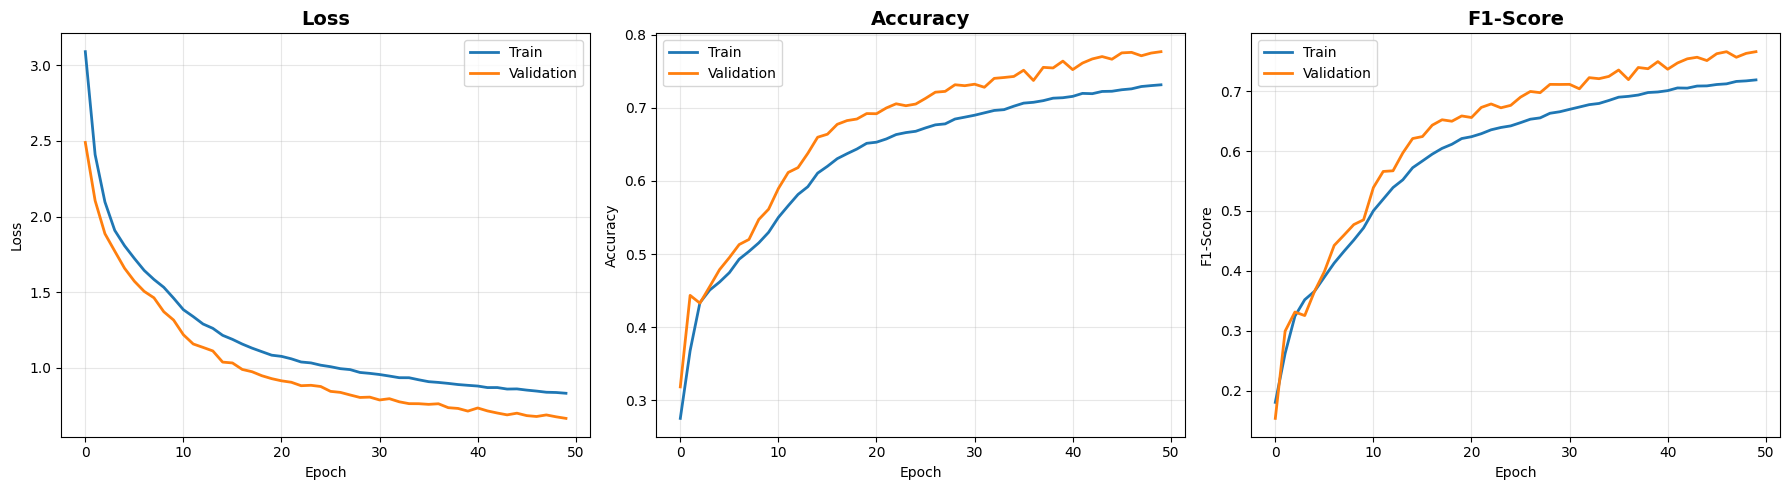

✓ Saved training history to images/DDI_training_history_08_Feb_17-09.png


In [80]:
# Train
history = trainer.train(
    data['node_features'], data['adj_mat'], data['edge_index'],
    data['edge_labels'], data['train_mask'], data['val_mask'],
    epochs=50, lr=0.001, weight_decay=5e-4, patience=30
)

# Plot history
plot_training_history(history)


In [81]:
# Load best model and evaluate
loaded_model = model.load_state_dict(torch.load(f'models/best_GAT_DDI_{timestamp}.pth'))
# results = evaluate_model(model, data, device)


In [82]:
# Save results
saved_model = torch.save({
    'config': config,
    'history': history,
    'results': results,
    'timestamp': timestamp
}, f'models/GAT_DDI_results_{timestamp}.pth')

# save_file(model.state_dict(), f'models/best_GAT_DDI_{timestamp}.safetensors')

print(f"\n✅ All results saved!")
print(f"• Model: models/best_GAT_DDI_{timestamp}.pth")


✅ All results saved!
• Model: models/best_GAT_DDI_08_Feb_17-09.pth


In [83]:
# Evaluating Model
# Load best model and evaluate

model.load_state_dict(torch.load(f'models/best_GAT_DDI_{timestamp}.pth'))

evaluator = ModelEvaluator(model, device)

test_results = evaluator.test(data)

print(f"🎯 Test Result Accuracy: {test_results['accuracy']:.4f}")
print("\n📊 Classification Report:")
print(classification_report(test_results['true_labels'], test_results['predictions']))

{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 87.0}, '2': {'precision': 0.9937888198757764, 'recall': 1.0, 'f1-score': 0.9968847352024922, 'support': 160.0}, '3': {'precision': 0.5766634522661523, 'recall': 0.8242591316333563, 'f1-score': 0.678581560283688, 'support': 1451.0}, '4': {'precision': 0.926829268292683, 'recall': 0.475, 'f1-score': 0.628099173553719, 'support': 80.0}, '5': {'precision': 0.7638533674339301, 'recall': 0.9481481481481482, 'f1-score': 0.846081208687441, 'support': 945.0}, '6': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7.0}, '7': {'precision': 0.6623376623376623, 'recall': 0.7083333333333334, 'f1-score': 0.6845637583892618, 'support': 72.0}, '8': {'precision': 0.8064516129032258, 'recall': 0.837138508371385, 'f1-score': 0.8215085884988798, 'support': 657.0}, '9': {'precision': 0.7613636363636364, 'recall': 0.7403314917127072, 'f1-score': 0.7507002801

## 8. Saving Logs and Tracks

In [ ]:
# 1. Prepare the new log entry with rounded values
current_log = {
    "date": timestamp,
    "graph_details": {
        "num_nodes": data['node_features'].shape[0],  # ✅ ADD: Number of drugs
        "num_edges": data['edge_index'].shape[1],  # ✅ FIX: Total edges (not just first row)
        "num_interaction_types": data['n_classes'],
        "feature_dimension": data['node_features'].shape[1]
    },
    "config": config,
    "runtime_info": {
        "device": str(device),
        "total_parameters": sum(p.numel() for p in model.parameters()),
        "trainable_parameters": sum(p.numel() for p in model.parameters() if p.requires_grad),  # ✅ ADD
        "model_size_mb": round(sum(p.numel() for p in model.parameters()) * 4 / 1024 / 1024, 2),  # ✅ ADD
        "training_edges": int(data['train_mask'].sum()),
        "validation_edges": int(data['val_mask'].sum()),
        "test_edges": int(data['test_mask'].sum())  # ✅ ADD: Test set size
    },
    "training_info": {  # ✅ ADD: Training details
        "epochs_completed": len(history['train_loss']),
        "best_epoch": history['val_f1'].index(max(history['val_f1'])) + 1,
        "learning_rate": 0.001,  # From your training config
        "batch_size": 7000,
        "weight_decay": 5e-4
    },
    "metrics": {
        # Training metrics (rounded to 3 decimals)
        "train_loss": round(history['train_loss'][-1], 3),  # ✅ ROUNDED
        "train_acc": round(history['train_acc'][-1], 3),    # ✅ ROUNDED
        "train_f1": round(history['train_f1'][-1], 3),      # ✅ ROUNDED
        
        # Validation metrics (rounded to 3 decimals)
        "val_loss": round(history['val_loss'][-1], 3),      # ✅ ROUNDED
        "val_acc": round(history['val_acc'][-1], 3),        # ✅ ROUNDED
        "val_f1": round(history['val_f1'][-1], 3),          # ✅ ROUNDED
        
        # Best validation metrics
        "best_val_acc": round(max(history['val_acc']), 3),  # ✅ ADD
        "best_val_f1": round(max(history['val_f1']), 3),    # ✅ ADD
        
        # Test metrics (if available)
        "test_acc": round(results['accuracy'], 3) if 'results' in locals() else None,  # ✅ ADD
        "test_f1": round(results['f1_score'], 3) if 'results' in locals() and 'f1_score' in results else None  # ✅ ADD
    }
}

# 2. File handling: Load existing data or create a new list
log_file = 'model_evals_log.json'

if os.path.exists(log_file):
    with open(log_file, 'r') as f:
        try:
            logs_list = json.load(f)
            if not isinstance(logs_list, list):
                logs_list = []
        except json.JSONDecodeError:
            logs_list = []
else:
    logs_list = []

# 3. Insert new log at the TOP (index 0)
logs_list.insert(0, current_log)

# 4. Save back to file with nice formatting
with open(log_file, 'w') as f:
    json.dump(logs_list, f, indent=4)

print(f"(✓) Log successfully saved to {log_file}!")


🚀 Log successfully saved to model_evals_log.json!

📊 Summary:
   • Test Accuracy: 0.809
   • Test F1-Score: 0.795
   • Best Val F1: 0.766
   • Total Epochs: 50


## 8. Model Analysis and Insights

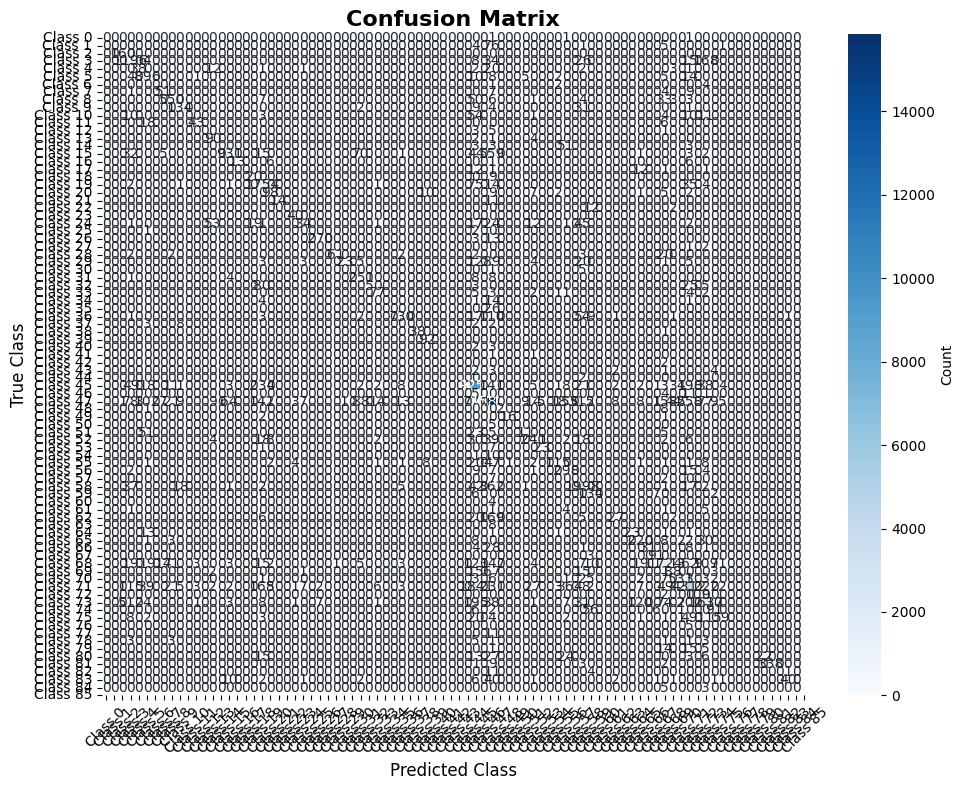

In [88]:
def plot_confusion_matrix(conf_matrix, class_names, save_path=f'images/GAT_confusion_matrix_{timestamp}.png'):
    """
    Plot confusion matrix with better styling
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Class', fontsize=12)
    plt.ylabel('True Class', fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Plot confusion matrix
class_names = [f'Class {i}' for i in range(data['n_classes'])]
plot_confusion_matrix(test_results['confusion_matrix'], class_names)

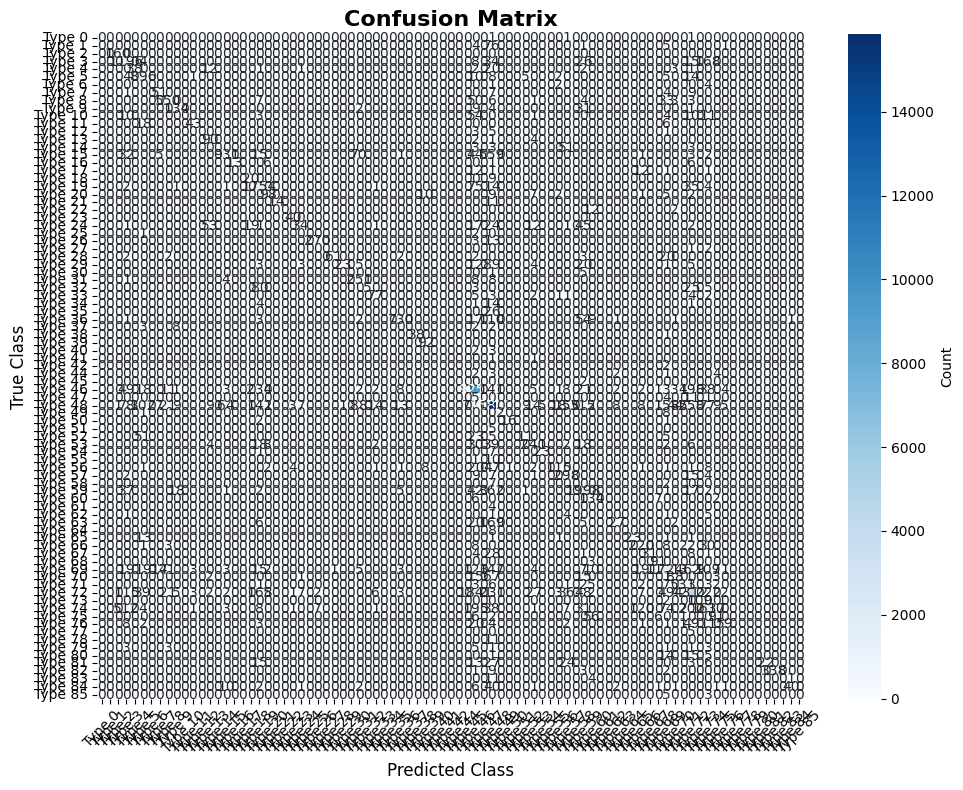

In [89]:
# Plot confusion matrix - only classes present in test set
unique_labels = np.unique(test_results['true_labels'])
class_names = [f'Type {i}' for i in unique_labels]
plot_confusion_matrix(test_results['confusion_matrix'], class_names)


In [95]:
# Analyze model performance
def analyze_results(history, test_results, data, model):
    """
    Provide comprehensive analysis of model performance
    """
    print("📈 MODEL PERFORMANCE ANALYSIS")
    print("="*60)
    
    # Training metrics
    print(f"\nTraining Metrics:")
    print(f"• Final Training Accuracy: {history['train_acc'][-1]:.4f}")
    print(f"• Final Validation Accuracy: {history['val_acc'][-1]:.4f}")
    print(f"• Best Validation Accuracy: {max(history['val_acc']):.4f}")
    print(f"• Final Training F1: {history['train_f1'][-1]:.4f}")
    print(f"• Final Validation F1: {history['val_f1'][-1]:.4f}")
    print(f"• Best Validation F1: {max(history['val_f1']):.4f}")
    print(f"• Total Epochs: {len(history['train_loss'])}")
    
    # Test metrics
    print(f"\nTest Metrics:")
    print(f"• Test Accuracy: {test_results['accuracy']:.4f}")
    if 'f1_score' in test_results:
        print(f"• Test F1-Score: {test_results['f1_score']:.4f}")
    
    # Per-class performance (only for classes in test set)
    print(f"\n📊 Per-Class Performance:")
    unique_labels = np.unique(test_results['true_labels'])
    
    for label in unique_labels:
        label_str = str(label)
        if label_str in test_results['classification_report']:
            report = test_results['classification_report'][label_str]
            precision = report['precision']
            recall = report['recall']
            f1 = report['f1-score']
            print(f"   • Type {label}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")
    
    # Model complexity
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"\n🔧 Model Complexity:")
    print(f"   • Total Parameters: {total_params:,}")
    print(f"   • Trainable Parameters: {trainable_params:,}")
    print(f"   • Model Size: ~{total_params * 4 / 1024 / 1024:.2f} MB")
    
    # Dataset info
    print(f"\n📊 Dataset Info:")
    print(f"   • Total Drugs (Nodes): {data['node_features'].shape[0]}")
    print(f"   • Total Interactions (Edges): {data['edge_index'].shape[1]}")
    print(f"   • Feature Dimension: {data['node_features'].shape[1]}")
    print(f"   • Number of Interaction Types: {data['n_classes']}")
    print(f"   • Classes in Test Set: {len(unique_labels)}")

# Run analysis
analyze_results(history, test_results, data, model)


📈 MODEL PERFORMANCE ANALYSIS

Training Metrics:
• Final Training Accuracy: 0.7317
• Final Validation Accuracy: 0.7770
• Best Validation Accuracy: 0.7770
• Final Training F1: 0.7188
• Final Validation F1: 0.7659
• Best Validation F1: 0.7659
• Total Epochs: 50

Test Metrics:
• Test Accuracy: 0.7802
• Test F1-Score: 0.7699

📊 Per-Class Performance:
   • Type 0: Precision=0.000, Recall=0.000, F1=0.000
   • Type 1: Precision=0.000, Recall=0.000, F1=0.000
   • Type 2: Precision=0.994, Recall=1.000, F1=0.997
   • Type 3: Precision=0.577, Recall=0.824, F1=0.679
   • Type 4: Precision=0.927, Recall=0.475, F1=0.628
   • Type 5: Precision=0.764, Recall=0.948, F1=0.846
   • Type 6: Precision=0.000, Recall=0.000, F1=0.000
   • Type 7: Precision=0.662, Recall=0.708, F1=0.685
   • Type 8: Precision=0.806, Recall=0.837, F1=0.822
   • Type 9: Precision=0.761, Recall=0.740, F1=0.751
   • Type 10: Precision=0.000, Recall=0.000, F1=0.000
   • Type 11: Precision=0.843, Recall=0.642, F1=0.729
   • Type 12: 